# GPU Accelerated dataset analysis, visualization and outlier detection

Dataset analysis is a crucial part of data curation. One of the fundamental aspects of this analysis is to be able to visualize high dimensional data in low dimensions (<=3). We can identify patterns in our data, and also identify ouliers. This better enables us to identify how we want to proceed: Exclude the outliers or modify training strategies to account for them or root cause a failure mode in a simulation.

This tutorial walks one through how we can do this data analysis for CFD designs using Nvidia RAPIDS.

The algorithm to do this is outlined below:

1. Run ETL on the DrivAerML and AhmedML datasets using Curator. Instructions can be found [here](./README.md). We will use DrivAerML as the `train` dataset, and AhmedML as the `test` dataset. The idea here is that we should be able to programatically detect the AhmedML data points as outliers, since they're vastly different from the DrivAerML dataset.
2. Feature engineering - We want to extract useful features from our raw geometries. This is essential since we do not want to use all the points of the raw geometries (these would be a very large number), and we want to be able to pick a standard n-dimensional vector across different datasets.
3. Compute a low dimensional (in this case, 2D) representation of our high dimensional features across the entire dataset. We will use GPU accelerated Uniform Manifold Approximation and Projection (UMAP) to achieve this.
4. Compute clusters on this low dimensional representation, and perform outlier detection.
5. Plot the final embeddings, and analyze the results.

We will now describe each of these steps in detail, while also providing code snippets to execute them.

## Run ETL

DrivAerML and AhmedML are popular datasets used in the external aerodynamics domain. Please follow the instructions [here](./README.md) to run ETL on them. This will convert the datasets into an optimized Zarr format (or NumPy) to perform further analysis/AI model training.

## Feature Engineering

We'll compute a statistical feature descriptor per geometry.
We want the feature descriptor to be sufficiently informative of the entire geometry, but also of a reasonable dimension. 

To perform this, let's pick some features that capture the local space of the geometry:

1. Mean and standard deviation of the areas of all the meshes - 2 dimensions
2. Mean and standard deviation of the distance of mesh centers to their centroids (this captures the spread of the triangles) - 2 dimensions

Let's also pick some features that capture the global space of the geometry:
1. 3 Eigenvalues when we perform Principal Component Analysis on the coordinates - 3 dimensions

This produces a 7D vector per geometry, that nicely captures both local and global features.
The simple snippet of code below performs this task.

In [124]:
import cupy as cp
import numpy as np


def compute_feature_descriptor(
        areas_zarr,
        coords_zarr,
        centers_zarr
    ):
    """
    Compute a statistical feature descriptor vector using CuPy.
    
    Parameters:
        areas_zarr: Zarr array of triangle areas
        coords_zarr: Zarr array of shape (N, 3) with all surface point coordinates
        centers_zarr: Zarr array of shape (M, 3) with triangle center coordinates
    
    Returns:
        descriptor (np.ndarray): shape (10,)
    """

    # 1–2: Surface area stats
    areas_cp = cp.asarray(areas_zarr)
    surface_area_mean = float(cp.mean(areas_cp).get())
    surface_area_std = float(cp.std(areas_cp).get())

    # 3–4: Triangle center spread
    centers_cp = cp.asarray(centers_zarr)
    mesh_centroid = cp.mean(centers_cp, axis=0)
    dists = cp.linalg.norm(centers_cp - mesh_centroid, axis=1)
    centroid_dist_mean = float(cp.mean(dists).get())
    centroid_dist_std = float(cp.std(dists).get())

    # 5–7: PCA eigenvalues of point cloud
    coords_cp = cp.asarray(coords_zarr)
    centered = coords_cp - cp.mean(coords_cp, axis=0)
    cov = cp.cov(centered.T)
    eigvals = cp.linalg.eigvalsh(cov)  # Already sorted ascending
    eigvals = cp.flip(eigvals)  # Flip to descending
    eigvals_norm = eigvals / cp.sum(eigvals)

    pca_eigvals = eigvals_norm.get()  # Convert to NumPy


    # Final descriptor vector
    descriptor = np.array([
        surface_area_mean,
        surface_area_std,
        centroid_dist_mean, centroid_dist_std,
        pca_eigvals[0], pca_eigvals[1], pca_eigvals[2],
    ], dtype=np.float32)

    return descriptor

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a popular technique that finds a low dimensional embedding of the data that approximates an underlying manifold.
Nvidia RAPIDS provides a [GPU accelerated implementation](https://docs.rapids.ai/api/cuml/stable/api/#umap).
The original paper can be found [here](https://arxiv.org/abs/1802.03426).
The below snippet is a thin wrapper around the RAPIDS implementation of UMAP.
We will feed in the 7D vectors that we computed using the `compute_feature_descriptor` and obtain 2D embeddings.

**Note**: UMAP has several hyperparameters that can be tuned. Please refer to the API docs for more insights.
The below snippet uses reasonable values for this tutorial.

In [125]:
import cuml


def run_umap_gpu(descriptor_matrix_np, n_neighbors=20, min_dist=0.1):
    descriptors_cp = cp.asarray(descriptor_matrix_np.astype(np.float32))

    umap_model = cuml.manifold.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
    )    
    embedding_cp = umap_model.fit_transform(descriptors_cp)

    embedding_np = cp.asnumpy(embedding_cp)
    return embedding_np

## Clustering using GPU accelerated HDBSCAN

Hierarchical DBSCAN is a clustering algorithm that recursively merges pairs of clusters that minimally increases a given linkage distance. The API docs can be found [here](https://docs.rapids.ai/api/cuml/stable/api/#hdbscan).
This [blog post](https://developer.nvidia.com/blog/faster-hdbscan-soft-clustering-with-rapids-cuml/) explains the algorithm in detail.
The below code snippet defines the clustering model.

**NOTE**: HDBSCAN has several hyperparameters as well. Tuning these is an essential step to obtaining sensible data analysis results.

In [126]:
clusterer = cuml.cluster.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    prediction_data=True,
    cluster_selection_epsilon=1.5,
    allow_single_cluster=True,
)

## Run the pipeline

The code below puts together the whole pipeline:
1. Loads the data (STL keys) from Zarr stores
2. Computes the feature vectors
3. Computes the UMAP embeddings
4. Runs clustering
5. Performs outlier detection and plots the results. Outlier detection here is simple: If the clustering algorithm returns a `-1`, or if the probability of the point belonging to a cluster is < 0.5.
**Note**: Please remember to run ETL using Curator on the two datasets before running the pipeline.

As we can see below, we can clearly see that the DrivAerML and AhmedML data points form different clusters.
**Note how the DrivAerML data points all form a nice cluster together, with the AhmedML data points being plotted far away as their own cluster(outliers). DrivAerML points are in green, while the AhmedML outliers are in black**

In [127]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import zarr

train_cluster_color_map = {
    -1: 'blue',
    0: 'green',
    1: 'red',
}
test_cluster_color_map = {
    -1: 'black',
    0: 'red',
    1: 'green',
    2: 'purple',
    3: 'orange',
    4: 'yellow',
    5: 'pink',
}

def plot_umap_embeddings_with_probabilities(
        training_dataset_embeddings,
        training_dataset_name = "Train dataset",
        test_dataset_embeddings = None,
        test_dataset_name = "Test dataset",
        train_dataset_cluster_labels = None,
        test_dataset_cluster_labels = None,
        train_dataset_probabilities = None,
        test_dataset_probabilities = None,
        title="UMAP Projection", 
        outlier_threshold=0.5,
    ):
    """
    Plot UMAP embeddings with probability-based outlier detection.
    
    Args:
        training_dataset_embeddings: Array of training dataset embeddings
        training_dataset_name: Name of the training dataset
        test_dataset_embeddings: Array of test dataset embeddings
        test_dataset_name: Name of the test dataset
        train_dataset_cluster_labels: Array of training dataset cluster labels
        test_dataset_cluster_labels: Array of test dataset cluster labels
        train_dataset_probabilities: Array of training dataset cluster membership probabilities
        test_dataset_probabilities: Array of test dataset cluster membership probabilities
        title: Title for the plot
        outlier_threshold: Probability threshold below which points are considered outliers
    """
    plt.figure(figsize=(12, 10))
    
    # Define default colors for different datasets
    train_dataset_color = 'blue'
    test_dataset_color = 'red'

    # Plot training dataset
    if train_dataset_cluster_labels is not None:
        unique_clusters = np.unique(train_dataset_cluster_labels)
        for cluster_label in unique_clusters:
            mask = train_dataset_cluster_labels == cluster_label
            plt.scatter(
                training_dataset_embeddings[mask, 0],
                training_dataset_embeddings[mask, 1],
                c=[train_cluster_color_map[cluster_label]],
                marker='o',
                s=(30 + 70 * train_dataset_probabilities[mask]).astype(int), 
                edgecolor='k', alpha=0.8,
                label=f'{training_dataset_name} (cluster {cluster_label})')
    else:
        plt.scatter(
            training_dataset_embeddings[:, 0],
            training_dataset_embeddings[:, 1],
            c=train_dataset_color, marker='o', s=80, 
            edgecolor='k', alpha=0.8, 
            label=f'{training_dataset_name}'
        )
    # Add text annotations every 10 points
    for i, (x, y) in enumerate(training_dataset_embeddings):
        if i % 10 == 0:
            plt.annotate(f'{i}', (x, y), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                color=train_dataset_color, alpha=0.7))

    # Plot test dataset
    if test_dataset_cluster_labels is not None:
        unique_clusters = np.unique(test_dataset_cluster_labels)
        for cluster_label in unique_clusters:
            plt.scatter(
                test_dataset_embeddings[:, 0],
                test_dataset_embeddings[:, 1],
                c=test_cluster_color_map[cluster_label],
                marker='o',
                s=(30 + 70 * test_dataset_probabilities).astype(int), 
                edgecolor='k', alpha=0.8, 
                label=f'{test_dataset_name} (cluster {cluster_label})'
            )            

            # Outlier detection
            mask = test_dataset_cluster_labels == cluster_label
            is_outlier = test_dataset_probabilities[mask] < outlier_threshold
            if is_outlier.sum() > 0:
                masked_outlier_points = test_dataset_embeddings[mask][is_outlier]
                masked_test_dataset_probabilities = test_dataset_probabilities[mask][is_outlier]
                plt.scatter(
                    masked_outlier_points[:, 0],
                    masked_outlier_points[:, 1],
                    c=test_cluster_color_map[-1],
                    marker='x',
                    s=(30 + 70 * masked_test_dataset_probabilities).astype(int), 
                    linewidth=2, alpha=0.8, 
                    label=f'{test_dataset_name} (outlier)'
                )
            if is_outlier.sum() < len(mask):
                masked_inlier_points = test_dataset_embeddings[mask][~is_outlier]
                masked_inlier_probabilities = test_dataset_probabilities[mask][~is_outlier]
                plt.scatter(
                    masked_inlier_points[:, 0],
                    masked_inlier_points[:, 1],
                    c=test_cluster_color_map[cluster_label],
                    marker='o', s=(30 + 70 * masked_inlier_probabilities).astype(int), 
                    edgecolor='k', alpha=0.8, 
                    label=f'{test_dataset_name} (cluster {cluster_label})'
                )
    else:
        plt.scatter(
            test_dataset_embeddings[:, 0],
            test_dataset_embeddings[:, 1],
            c=test_dataset_color, marker='o', s=80, 
            edgecolor='k', alpha=0.8, 
            label=f'{test_dataset_name}'
        )

    # Add text annotations every 10 points
    for i, (x, y) in enumerate(test_dataset_embeddings):
        if i % 10 == 0:
            plt.annotate(f'{i}', (x, y), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='black'),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                                color=test_dataset_color, alpha=0.7))

    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True, alpha=0.3)
    
    # Create custom legend to avoid duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Load the data
def extract_key_data(zarr_path, required_keys):

    stores = [s for s in os.listdir(zarr_path) if s.endswith('.zarr')]
    stores = sorted(stores)

    data = {}
    for key in required_keys:
        data[key] = []
    data['valid_stores'] = []

    for store_name in stores:
        try:
            store_path = os.path.join(zarr_path, store_name)
            store = zarr.open(store_path, mode='r')
            
            # Check if all required keys are accessible before appending anything
            required_keys = ['stl_areas', 'stl_coordinates', 'stl_centers']
            all_keys_valid = True
            
            for key in required_keys:
                if key not in store:
                    print(f"Missing key '{key}' in store: {store_name}")
                    all_keys_valid = False
                    break
            
            # Only append data if all keys are valid
            if all_keys_valid:
                for key in required_keys:
                    data[key].append(store[key])
                data['valid_stores'].append(store_name)
            else:
                print(f"Skipping store {store_name} due to missing keys")
                
        except Exception as e:
            print("Error in store_name: ", store_name)
            print(e)

    print(f"Successfully loaded {len(data['valid_stores'])} stores")
    return data

drivaerml_zarr_path = '/mnt/datasets/drivaerml_stl_zarr'
ahmedml_zarr_path = '/mnt/datasets/ahmedml_stl_zarr'

drivaerml_extracted_data = extract_key_data(drivaerml_zarr_path, ['stl_areas', 'stl_coordinates', 'stl_centers'])
ahmedml_extracted_data = extract_key_data(ahmedml_zarr_path, ['stl_areas', 'stl_coordinates', 'stl_centers'])

drivaerml_descriptors = []
ahmedml_descriptors = []

for i in range(len(drivaerml_extracted_data['valid_stores'])):
    descriptor = compute_feature_descriptor(
        drivaerml_extracted_data['stl_areas'][i],
        drivaerml_extracted_data['stl_coordinates'][i],
        drivaerml_extracted_data['stl_centers'][i]
    )
    drivaerml_descriptors.append(descriptor)

drivaerml_descriptors = cp.asarray(drivaerml_descriptors)
print("Computed descriptors for drivaerml")

for i in range(len(ahmedml_extracted_data['valid_stores'])):
    descriptor = compute_feature_descriptor(
        ahmedml_extracted_data['stl_areas'][i],
        ahmedml_extracted_data['stl_coordinates'][i],
        ahmedml_extracted_data['stl_centers'][i]
    )
    ahmedml_descriptors.append(descriptor)

ahmedml_descriptors = cp.asarray(ahmedml_descriptors)
print("Computed descriptors for ahmedml")

Now that we have the pipelines setup, let's run it: We'll use all the DrivAerML data points, and add in 10 points of AhmedML.

In [ ]:
# Add a few points from AhmedML to the DrivAerML dataset to simulate outlier detection
num_ahmedml_points_to_add = 10

# Stack both datasets together for UMAP
combined_descriptors = np.vstack([drivaerml_descriptors, ahmedml_descriptors[:num_ahmedml_points_to_add]])
combined_embedding = run_umap_gpu(combined_descriptors)

Label count per cluster:   0    431
-1     10
Name: count, dtype: int64


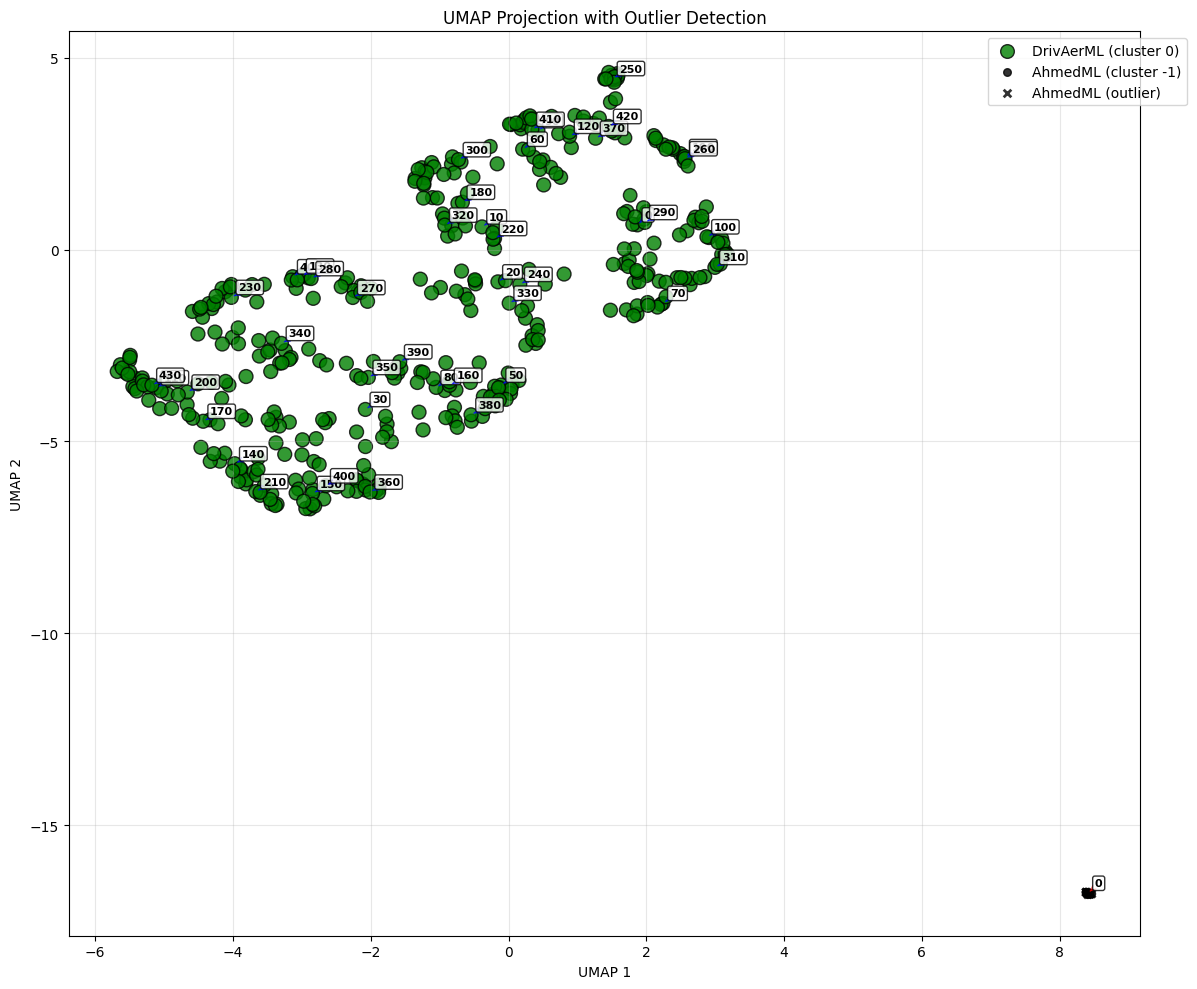

In [130]:
drivaerml_count = drivaerml_descriptors.shape[0]
clusterer.fit(cp.asarray(combined_embedding))

labels_all = cp.asnumpy(clusterer.labels_)
probs_all  = cp.asnumpy(clusterer.probabilities_)
print("Label count per cluster: ", pd.Series(cp.asnumpy(clusterer.labels_)).value_counts())

# Split the combined embedding back into separate arrays for plotting
drivaerml_embedding_np = combined_embedding[:drivaerml_count]
ahmedml_embedding_np = combined_embedding[drivaerml_count:]

# Usage:
embeddings = {
    'DrivAerML': drivaerml_embedding_np,
    'AhmedML': ahmedml_embedding_np,
}

plot_umap_embeddings_with_probabilities(
    training_dataset_embeddings=drivaerml_embedding_np,
    training_dataset_name="DrivAerML",
    test_dataset_embeddings=ahmedml_embedding_np,
    test_dataset_name="AhmedML",
    train_dataset_cluster_labels=labels_all[:drivaerml_count],
    test_dataset_cluster_labels=labels_all[drivaerml_count:],
    train_dataset_probabilities=probs_all[:drivaerml_count],
    test_dataset_probabilities=probs_all[drivaerml_count:],
    title="UMAP Projection with Outlier Detection",
    outlier_threshold=0.5
)